In [12]:
from rnn import Encoder
from preprocess import proc
import tensorflow as tf
from tqdm import tqdm
import pandas as pd

encoder = Encoder(300, 300, 100, 1)
encoder.load_weights("encoder.weights")

w2v_dict = dict()
f = open("./glove.840B.300d.txt", "rt", encoding='utf-8')
for i in tqdm(range(100000)):
    line = f.readline()
    els = line.split()
    token = els[0]
    try:
        value = tf.convert_to_tensor(list(map(float, els[1:])), dtype=tf.float32)
    except:
        break
    w2v_dict[token] = value
f.close()

def comment_text_to_vec(comment_text):
    p = proc(comment_text, [1, 2])
    tweet = []
    for word in p:
        if word in w2v_dict:
            tweet.append(w2v_dict[word])
    if len(tweet) == 0:
        return None
    tweet = tf.stack(tweet)
    tweet = tf.expand_dims(tweet, axis=1)
    tweet = tf.expand_dims(tweet, axis=3)
    enc_hidden = encoder.initialize_hidden_state()
    for word in tweet:
        out_t, enc_hidden = encoder(word, enc_hidden)
    return enc_hidden[0].numpy()


def cross_validation(model, X, y, scorer, cv=5):
    return cross_validate(estimator=model,
                          X=X,
                          y=y,
                          cv=cv,
                          scoring=scorer,
                          return_train_score=True)


train = pd.read_csv("./train.csv")[['target', 'comment_text']][:10000]
train['toxic'] = 1 * (train['target'] > 0.5)

print("Training")
X, y = [], []
for Xrow, yrow in tqdm(list(zip(train['comment_text'], train["toxic"]))[:500]):
    v = comment_text_to_vec(Xrow)
    if v is not None:
        X.append(v)
        y.append(yrow)

import numpy as np
X = np.stack(X)
y = np.array(y)




  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

Training


100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [1:15:50<00:00,  9.10s/it]


In [13]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

best = 0
pen_best = 0
inter_best = 0
for penalty in ('l1', 'l2', 'elasticnet', 'none'):
    solver = 'lbfgs'
    if penalty == 'elasticnet':
        solver = 'saga'
    if penalty == 'l1':
        solver = 'liblinear'
    for intercept in (True, False):
        m = LogisticRegression(penalty = penalty, fit_intercept = intercept, solver = solver)
        res = cross_validation(m, Xs, y, ['f1'], 5)
        if res['test_f1'].mean() > best:
            best = res['test_f1'].mean()
            pen_best = penalty
            inter_best = intercept

print(best, pen_best, inter_best)


C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\hp\anaconda3\lib\site-p

0.10210254700791385 l2 False


C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\hp\anaconda3\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\hp\anaconda3\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\hp\anaconda3\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fi

C:\Users\hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.926829268292683
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       114
           1       0.00      0.00      0.00         9

    accuracy                           0.93       123
   macro avg       0.46      0.50      0.48       123
weighted avg       0.86      0.93      0.89       123



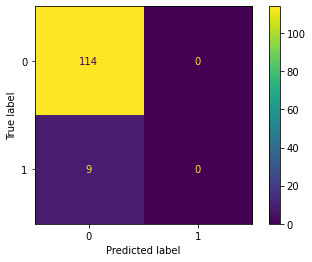

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split

m = LogisticRegression(penalty = 'l2', fit_intercept = True)
X_train, X_test, y_train, y_test = train_test_split(Xs, y)

m.fit(X_train, y_train)
print(m.score(X_test, y_test))
pred = m.predict(X_test)
f1_score(y_test, pred)
print(classification_report(y_test, pred))
plot_confusion_matrix(m, X_test, y_test)
plt.show()

In [15]:
m.score(X_train, y_train)

0.9700272479564033

In [16]:
aaa = m.predict(X_train)

In [17]:
f1_score(aaa, y_train)

0.0